In [1]:
!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1
!pip install -U scikit-learn
!pip install --upgrade matplotlib

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast (to revision v0.1.8.1) to /tmp/pip-req-build-s0qxvojc
  Running command git clone -q https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-s0qxvojc
  Running command git checkout -q e9f125fec47e13a6ba768bf9e5c362815e84d767


In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

In [3]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [4]:
stocks_close = pd.read_csv('btcStocks.csv', index_col=0)

In [5]:
stocks_close.head()

,btcClose
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [6]:
stocks_close.shape

(2491, 1)

# Train / Test

In [7]:
test = 0.1
train_ts = stocks_close[:int(-len(stocks_close)*test)]
train_ts.shape

(2242, 1)

In [8]:
test_ts = stocks_close[int(-len(stocks_close)*test):]
test_ts.shape

(249, 1)

In [9]:
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM
from ConvLSTM import ConvLSTM
from CnnLSTM import CnnLSTM

epochs = 50
batch_size = 16
n_steps = 5
n_outputs = 1
n_neurons = 50
loss = 'mean_squared_error'
optimizer = 'adam'

model = VanillaLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs)

history = model.train(train_ts, epochs=epochs, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
126/126 [==============================] - 2s 5ms/step - loss: 0.0132 - accuracy: 9.9354e-04 - val_loss: 6.3042e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
126/126 [==============================] - 0s 3ms/step - loss: 5.4864e-04 - accuracy: 9.9354e-04 - val_loss: 6.5394e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
126/126 [==============================] - 0s 3ms/step - loss: 5.2763e-04 - accuracy: 9.9354e-04 - val_loss: 7.3657e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
126/126 [===================

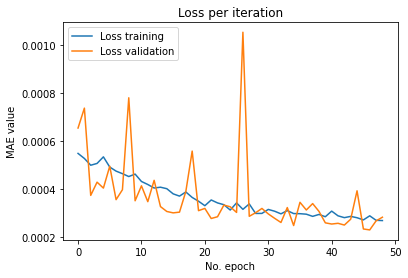

In [10]:
# Plot history: MAE
plt.plot(history['loss'][1:], label='Loss training')
plt.plot(history['val_loss'][1:], label='Loss validation')

plt.title('Loss per iteration')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

# Predict

In [11]:
train_ts.shape

(2242, 1)

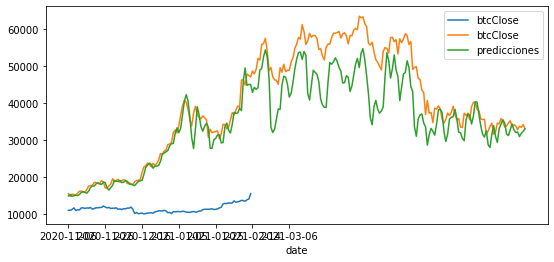

In [12]:
test = pd.concat([train_ts[-n_steps:], test_ts]) 
predictions = model.predict(test)
predictions = predictions.reshape(predictions.shape[0])
predictions_ts = pd.Series(data=predictions, index=test_ts.index)

train_plot_df = train_ts[-100:]
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
train_plot_df.plot(ax=ax, label='train')
test_ts.plot(ax=ax, label='test')
predictions_ts.plot(ax=ax, label='predicciones')
ax.legend();

# Evaluate

In [20]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :]['btcClose'] < row['btcClose'], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  train_evaluate = ts[:-n_evaluations*n_test]
  last_training = train_evaluate[-n_steps:]
  print('Iteration 1 started')
  model.train(train_evaluate, n_epochs, batch_size)

  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    predictions = model.predict(last_training)
    predictions = predictions.reshape(predictions.shape[1])
    predictions_ts = pd.DataFrame({'btcClose': predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(last_training, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(last_training, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(n_evaluations+1-i))
    new_train = pd.concat([last_training, test_evaluate])
    model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    last_training = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [21]:
n_evaluations = 100
n_outputs = 3

epochs = 40
batch_size = 16
n_steps = 5
n_outputs = 1
n_neurons = 30
loss = 'mean_squared_error'
optimizer = 'adam'
n_seed = 450

seed(n_seed)
tf.random.set_seed(n_seed)
model_evaluate = VanillaLSTM(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)
confusion_matrix = evaluate(model_evaluate,ts=stocks_close, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None
Iteration 1 started
Epoch 1/40
135/135 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 4.6577e-04 - val_loss: 0.0557 - val_accuracy: 0.0000e+00
Epoch 2/40
135/135 [==============================] - 0s 3ms/step - loss: 5.9744e-05 - accuracy: 4.6577e-04 - val_loss: 0.0311 - val_accuracy: 0.0042
Epoch 3/40
135/135 [==============================] - 0s 3ms/step - loss: 5.4427e-05 - accuracy: 4.6577e-04 - val_loss: 0.0268 - val_accuracy: 0.0042
Epoch 4/40
135/135 [===================

In [15]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

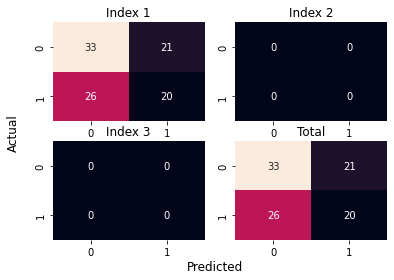

In [16]:
plot_confusion_matrix(confusion_matrix)

In [17]:
model_evaluate.export_model()

In [22]:
import time

def score_from_cm(confusion_matrix_array):
  total_cm = sum(confusion_matrix_array)
  total_score = total_cm[0][0] + total_cm[1][1]

  score_by_index = [x[0][0] + x[1][1] for x in confusion_matrix_array]
  score =  { 
      'total_score': total_score,
      'score_by_index': score_by_index
    }
  return score

def score_model_from_dict(score_dict):
  n_index = len(score_dict['score_by_index'])
  score = score_dict['total_score'] * pow(10, n_index * 3)
  for i in range(n_index):
    score += score_dict['score_by_index'][i] * pow(10, (n_index-(i+1))*3)
  print("score:", score)
  return score

def take_score(elem):
    return elem['score']

def grid_search(model_class, dataset, seeds=[0], optimizers=['adam'], losses=['mean_squared_error'], neurons=[50], steps=[1], n_outputs=3, epochs=[50], batch_sizes=[16], n_evaluations=10):
  models= list()
  n_combinations = len(seeds) * len(optimizers) * len(losses) * len(neurons) * len(steps) * len(epochs) * len(batch_sizes)
  print("Number of combinations to test:", n_combinations)
  starting_time = time.time()
  for n_seed in seeds:
    for optimizer in optimizers:
      for loss in losses:
        for n_neurons in neurons:
          for n_steps in steps:
            for n_epochs in epochs:
              for batch_size in batch_sizes:
                print("Seed: {}, Optimizer: {}, Neurons: {}, Steps: {}, Epochs: {}, Batch: {}".format(n_seed, optimizer, n_neurons, n_steps, n_epochs, batch_size))
                epoch_starting_time = time.time()
                seed(n_seed)
                tf.random.set_seed(n_seed)
                model = model_class(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)
                confusion_matrix = evaluate(model,ts=dataset, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=n_epochs)
                score_dict = score_from_cm(confusion_matrix)
                score = score_model_from_dict(score_dict)
                parameters = {
                    'model': str(model_class),
                    'seed': n_seed,
                    'optimizer': str(optimizer),
                    'loss': loss,
                    'neurons': n_neurons,
                    'steps': n_steps,
                    'epochs': n_epochs,
                    'batch_size': batch_size
                }
                model_score = {
                    'model': model,
                    'parameters': parameters,
                    'score': score,
                    'cm': confusion_matrix
                }
                models.append(model_score)
                models = sorted(models, key=take_score, reverse=True)
                print("Combinations tested", len(models), "/", n_combinations)
                epoch_ending_time = time.time()
                print("Epoch time(s):", epoch_ending_time - epoch_starting_time)
                print("Time since starting(min):", (epoch_ending_time - starting_time) / 60)
                models_left = n_combinations - len(models)
                time_per_model_s = (epoch_ending_time - starting_time) / len(models)
                print("Time left (min):", (time_per_model_s * models_left) / 60)
  return models


In [23]:
models = grid_search(VanillaLSTM, stocks_close, seeds=[0], steps=[5, 7], epochs=[30, 50, 70], neurons=[30, 50, 70], n_outputs=1, n_evaluations=300, optimizers=['adam'], losses=['mean_squared_error'])

Streaming output truncated to the last 5000 lines.
Epoch 23/50
123/123 [==============================] - 1s 5ms/step - loss: 3.1360e-04 - accuracy: 0.0010 - val_loss: 4.6308e-04 - val_accuracy: 0.0000e+00
Epoch 24/50
123/123 [==============================] - 1s 5ms/step - loss: 3.1286e-04 - accuracy: 0.0010 - val_loss: 3.8421e-04 - val_accuracy: 0.0000e+00
Epoch 25/50
123/123 [==============================] - 1s 5ms/step - loss: 3.0177e-04 - accuracy: 0.0010 - val_loss: 4.6200e-04 - val_accuracy: 0.0000e+00
Epoch 26/50
123/123 [==============================] - 1s 5ms/step - loss: 3.0092e-04 - accuracy: 0.0010 - val_loss: 3.7986e-04 - val_accuracy: 0.0000e+00
Epoch 27/50
123/123 [==============================] - 1s 5ms/step - loss: 2.9305e-04 - accuracy: 0.0010 - val_loss: 3.8275e-04 - val_accuracy: 0.0000e+00
Epoch 28/50
123/123 [==============================] - 1s 5ms/step - loss: 2.8671e-04 - accuracy: 0.0010 - val_loss: 3.8169e-04 - val_accuracy: 0.0000e+00
Epoch 29/50
123/123

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 192 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 193 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0062 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 194 started
1/1 [==============================] - 0s 6ms/step - loss: 6.0853e-05 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 195 started
1/1 [==============================] - 0s 6ms/step - loss: 2.1518e-04 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 196 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 197 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 198 started
1/1 [==============================] - 0s 8ms/step - loss: 0.0406 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 1/1
Iteration 143 started
1/1 [==============================] - 0s 14ms/step - loss: 0.0096 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 144 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 145 started
1/1 [==============================] - 0s 5ms/step - loss: 0.0413 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 146 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0546 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 147 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0117 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 148 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 149 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0098 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 150 started
1/1 [==============================] - 0s 5ms/step - loss: 0.0075 - accuracy: 0.0000e+00

In [24]:
models[0]

{'cm': [array([[78., 60.],
         [70., 92.]]), array([[0., 0.],
         [0., 0.]]), array([[0., 0.],
         [0., 0.]])],
 'model': <VanillaLSTM.VanillaLSTM at 0x7f57053d1cd0>,
 'parameters': {'batch_size': 16,
  'epochs': 70,
  'loss': 'mean_squared_error',
  'model': "<class 'VanillaLSTM.VanillaLSTM'>",
  'neurons': 50,
  'optimizer': 'adam',
  'seed': 0,
  'steps': 7},
 'score': 170170000000.0}

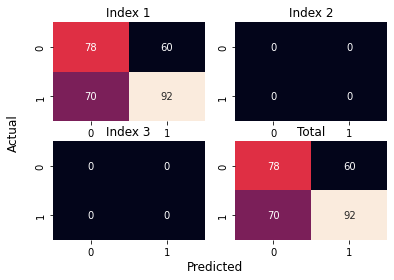

In [25]:
plot_confusion_matrix(models[0]['cm'])

In [26]:
models[0]['model'].export_model()